In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import os
import sys

if os.path.abspath('../../..') not in sys.path:
    sys.path.append(os.path.abspath('../../..'))

In [4]:
import json
import re
import logging

from collections import defaultdict

import tqdm

import numpy as np
import pandas as pd

from flashtext import KeywordProcessor

from gensim.parsing.preprocessing import (
    preprocess_string, 
    strip_tags,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    lower_to_unicode,
    strip_short,
    remove_stopwords,
)
from gensim.corpora.dictionary import Dictionary
from gensim.models import AuthorTopicModel as GensimAuthorTopicModel
from gensim.test.utils import temporary_file
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

from src.dataset import load_tweets, load_availability
from src.config import config

In [5]:
logging.basicConfig(
    format='%(asctime)s:%(levelname)s:%(message)s', 
    level=logging.WARNING,
    handlers=[
        logging.StreamHandler(),
    ]
)

In [6]:
def load_keywords(path=None):
    if path is None:
        path = '../../../data/external/keywords.v3.2.csv'
    df = pd.read_csv(path)
    output = defaultdict(set)
    for row in df.itertuples():
        phrase, topic = row.raw_keyword, row.label
        for token in phrase.split(' '):
            if len(token) > 2:
                output[topic].add(token)
    return {k: list(v) for k, v in output.items()}

keywords = load_keywords()

In [7]:
url_pattern = re.compile('\Bhttp[s]?://\S+')
hashtag_pattern = re.compile('\B\#[a-zA-Z0-9_]+')
mention_pattern = re.compile('\B\@[a-zA-Z0-9_]+')

In [8]:
class Document:
    def __init__(self, text, author=None):
        self.text = text
        self.author = author
        self.tokens = None
        
    def set_tokens(self, tokens):
        self.tokens = tokens
        return self
    
def load_documents(path=None):
    if path is None:
        path = '../../../data/interim/models/tweets_intra_subject_analysis.jsonl'
    with open(path, 'r') as fp:
        for line in tqdm.tqdm(fp.readlines(), desc='Loading Documents'):
            record = json.loads(line)
            text = record['tweet']['text']
            author = record['subject_id']
            d = Document(text=text, author=author)
            yield d

In [9]:
results = []

for doc in load_documents():
    hashtags = hashtag_pattern.findall(doc.text)
    tokens = preprocess_string(doc.text, filters=[
        lower_to_unicode,
        lambda x: url_pattern.sub(' ', x),
        lambda x: hashtag_pattern.sub(' ', x),
        lambda x: mention_pattern.sub(' ', x),
        strip_tags,
        strip_punctuation,
        strip_numeric,
        lambda x: x + ' '.join(hashtags),
        remove_stopwords,
        strip_short,
        strip_multiple_whitespaces, 
    ])
    doc.set_tokens(tokens)
    if len(doc.tokens) > 5:
        results.append(doc)

Loading Documents: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 820202/820202 [00:56<00:00, 14490.25it/s]


In [10]:
tokenized_docs = []
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Tokens')):
    tokenized_docs.append(doc.tokens)

author2doc = defaultdict(list)
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Author Docs')):
    author2doc[doc.author].append(i)
author2doc = dict(author2doc)
        
dictionary = Dictionary(tokenized_docs)

corpus = [dictionary.doc2bow(tokenized_doc) for tokenized_doc in tqdm.tqdm(tokenized_docs)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 649526/649526 [00:08<00:00, 80190.02it/s]


In [11]:
def create_eta(keywords, vocab, num_topics, pseudo_count=1e7, normalize=True):
    # create a (ntopics, nterms) matrix and fill with 1
    eta = np.full(shape=(num_topics, len(vocab)), fill_value=1)
    # for each topic in the seed dict
    topic2id = {topic: i for i, topic in enumerate(keywords)}
    # for each topic in the seed dict
    for topic, tokens in keywords.items():
        # for each seed token that is in vocab
        for token in tokens:
            if token in vocab.token2id:
                eta[topic2id[topic], vocab.token2id[token]] = pseudo_count
    if normalize:
        eta = np.divide(eta, eta.sum(axis=0))
    return eta

eta = create_eta(keywords, dictionary, len(keywords) + 1, len(corpus) // 100, normalize=True)

eta.shape

(6, 604753)

In [12]:
# Set training parameters.
kwargs = {
    'passes': 20,
    'iterations': 400,
    'chunksize': 2000,
}

with temporary_file('serialized') as s_path:
    model = GensimAuthorTopicModel(
        corpus,
        author2doc=author2doc, 
        chunksize=kwargs.get('chunksize', 1000),
        passes=kwargs.get('passes', 1),
        iterations=kwargs.get('iterations', 50),
        id2word=dictionary, 
        num_topics=eta.shape[0],
        eta=eta,
        serialized=True, 
        serialization_path=s_path,
        eval_every=None,
    )

In [13]:
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

In [14]:
# Train the model on the corpus.
for topic_id in range(model.num_topics):
    for term_id, p in model.get_topic_terms(topic_id):
        print('{:>02} {:<30s}{:0.3f}'.format(topic_id, dictionary[term_id], p))

00 million                       0.010
00 black                         0.010
00 broward                       0.007
00 reporter                      0.007
00 oil                           0.006
00 gas                           0.005
00 tested                        0.004
00 email                         0.004
00 editor                        0.004
00 plant                         0.004
01 que                           0.009
01 increase                      0.008
01 puerto                        0.007
01 species                       0.007
01 episode                       0.007
01 https                         0.006
01 los                           0.005
01 rico                          0.005
01 las                           0.004
01 por                           0.003
02 climate                       0.007
02 change                        0.004
02 journalists                   0.004
02 students                      0.003
02 stories                       0.003
02 journalism            

In [15]:
model.save('../../../data/interim/models/models/v1.pt')

In [72]:
tropic_proba = []

# results[i].text

for i in tqdm.tqdm(range(len(results))):
    tropic_proba.append(list(zip(*model.get_new_author_topics(corpus[i:i+1])))[1])
    
tropic_proba = np.array(tropic_proba)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452347/452347 [02:09<00:00, 3490.85it/s]


In [92]:
np.unique(tropic_proba.argmax(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 50292, 394793,   3890,    300,   2202,    870]))

In [ ]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

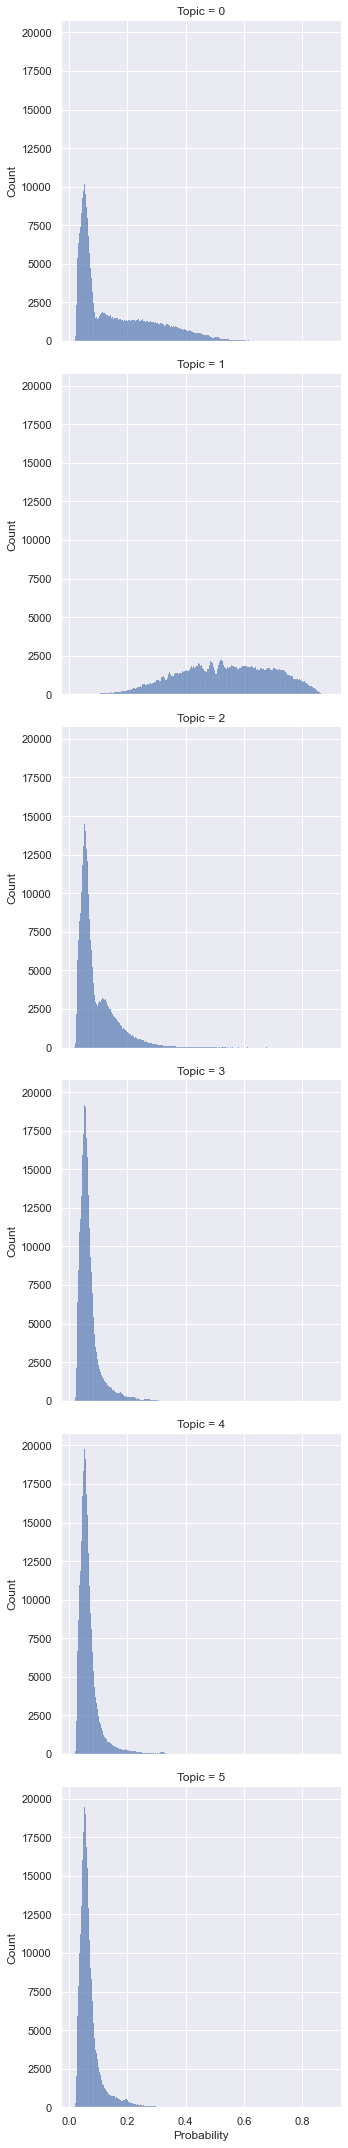

In [89]:
fig_data = [{'Topic': i, 'Probability': p} for i in range(tropic_proba.shape[1]) for p in tropic_proba[:, i]]

fig_df = pd.DataFrame(fig_data)

sns.displot(fig_df, x='Probability', row='Topic')